In [28]:
import os
import sys

import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
sns.set(style='whitegrid', rc={
    'figure.figsize':(12,8),
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Lucida Grande'
})

from simulated_utils import compare
from simulated_utils import SingleSmallPeakCtsBanditEnv, BanditEnv

In [2]:
def filter_df(df, **kwargs):
    for k,v in kwargs.items():
        df = df[df[k] == v]
    return df

In [4]:
env = SingleSmallPeakCtsBanditEnv(noise_std=0.1)
data_beta = compare(env, 'beta', n_steps=100, repeats=20,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=10)

a = data_beta['pd_param_0_mean']
b = data_beta['pd_param_1_mean']
data_beta['mean'] = a / (a + b)
data_beta['std'] = (a * b / (a + b + 1)).apply(np.sqrt) / (a + b)
# Scale it to [-3,3]
data_beta['mean'] = data_beta['mean'] * 3 - 1.5
data_beta['std'] = data_beta['std'] * 3

In [5]:
env = SingleSmallPeakCtsBanditEnv(noise_std=0.1)
data_gaussian = compare(env, 'gaussian', n_steps=100, repeats=20,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=10)
data_gaussian['mean'] = data_gaussian['pd_param_0_mean']
data_gaussian['std'] = data_gaussian['pd_param_1_mean']

In [49]:
env = SingleSmallPeakCtsBanditEnv(noise_std=0.1)
data_gaussian_kl = compare(env, 'gaussian', n_steps=100, repeats=20,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=10)
data_gaussian_kl['mean'] = data_gaussian_kl['pd_param_0_mean']
data_gaussian_kl['std'] = data_gaussian_kl['pd_param_1_mean']

In [50]:
import pickle
with open('single_small_peak_1d_gaussian_all.pkl', 'wb') as f:
    pickle.dump(data_gaussian_kl, f)

In [26]:
import pickle
with open('single_small_peak_1d_gaussian.pkl', 'wb') as f:
    pickle.dump(data_gaussian, f)
with open('single_small_peak_1d_beta.pkl', 'wb') as f:
    pickle.dump(data_beta, f)

In [33]:
with open('single_small_peak_1d_gaussian.pkl', 'rb') as f:
    data_gaussian_all = pickle.load(f)

In [ ]:
# Discretize in intervals of 0.1 between -1.5 and 1.5
# two high reward blocks in -1.0 - -0.8
avg_rewards = 0.1 * np.random.randn(30)
avg_rewards[:2] = 1.0
env = BanditEnv(avg_rewards=avg_rewards)
data_discrete = compare(env, 'discrete', n_steps=100, repeats=20,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=10)

/home/eecs/chloehsu/ppo_ablation/code-for-paper/analysis/simulated_utils.py:289: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.logits = torch.nn.Parameter(init)


In [ ]:
with open('single_small_peak_1d_discrete.pkl', 'wb') as f:
    pickle.dump(data_discrete, f)

In [ ]:
%matplotlib inline

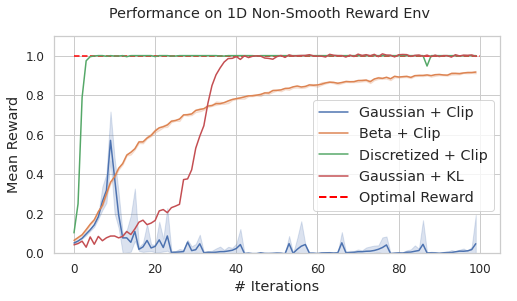

In [47]:
n_boot = 10

data_gaussian = filter_df(data_gaussian, method='Clipping')
data_beta = filter_df(data_beta, method='Clipping')
data_discrete = filter_df(data_discrete, method='Clipping')
data_kl_rev = filter_df(data_gaussian_kl, method='Reverse KL')
data_kl_for = filter_df(data_gaussian_kl, method='Forward KL')

fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey='row')
sns.lineplot(data=data_gaussian, x='iter', y='mean_reward', ax=axes, n_boot=n_boot,
            label='Gaussian + Clip')
sns.lineplot(data=data_beta, x='iter', y='mean_reward',ax=axes, n_boot=n_boot,
            label='Beta + Clip')
sns.lineplot(data=data_discrete, x='iter', y='mean_reward',ax=axes, n_boot=n_boot,
            label='Discretized + Clip')
sns.lineplot(data=data_kl_rev, x='iter', y='mean_reward',ax=axes, n_boot=n_boot,
            label='Gaussian + KL')
#sns.lineplot(data=data_kl_for, x='iter', y='mean_reward',ax=axes, n_boot=n_boot,
#            label='Gaussian + Forward KL')
axes.set_ylabel('Mean Reward')
handles, labels = axes.get_legend_handles_labels()
axes.get_legend().remove()
axes.set_xlabel('# Iterations')
axes.set_ylim([0, 1.1])

from matplotlib.lines import Line2D
axes.hlines(1.0, 0, 100, colors='red', linestyles='dashed')
redline = Line2D([0], [0], color='red', ls='dashed', lw=2, label='Optimal Reward')
fig.align_ylabels(axes)
fig.legend(handles + [redline], labels+['Optimal Reward'],
           loc=(0.605,0.3), ncol=1)

fig.suptitle('Performance on 1D Non-Smooth Reward Env')
plt.show()

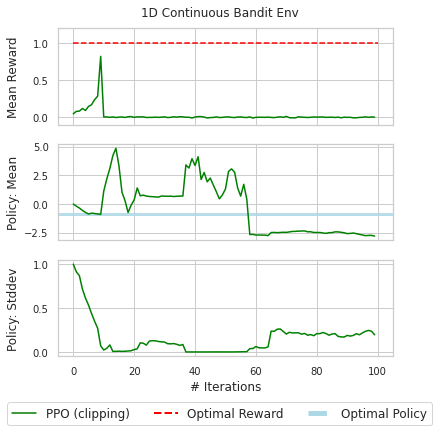

In [46]:
n_boot = 10

data_gaussian = data_gaussian[data_gaussian.method == 'Clipping']
#data_beta = data_beta[data_beta.method != 'Unregularized']

fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True, sharey='row')
sns.lineplot(data=data_gaussian, x='iter', y='mean_reward', hue='method', ax=axes[0], n_boot=n_boot,
            palette=['green'])
axes[0].set_ylabel('Mean Reward')
sns.lineplot(data=data_gaussian, x='iter', y='mean', hue='method', ax=axes[1], n_boot=n_boot,
            palette=['green'])
axes[1].set_ylabel('Policy: Mean')
sns.lineplot(data=data_gaussian, x='iter', y='std', hue='method', ax=axes[2], n_boot=n_boot,
            palette=['green'])
axes[2].set_ylabel('Policy: Stddev')

handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    ax.get_legend().remove()
    ax.set_xlabel('# Iterations')

from matplotlib.lines import Line2D
axes[0].hlines(1.0, 0, 100, colors='red', linestyles='dashed')
redline = Line2D([0], [0], color='red', ls='dashed', lw=2, label='Optimal Reward')
blueline = Line2D([0], [0], color='lightblue', ls='dashed', lw=5, label='Optimal Policy Mean')
axes[0].set_ylim([-0.1, 1.2])
#axes[1].set_ylim([-3, 3])

axes[1].axhspan(-1, -0.8, alpha=0.8, color='lightblue')

fig.align_ylabels(axes)
fig.subplots_adjust(bottom=0.17, top=0.93)
fig.legend(handles[1:] + [redline, blueline], ['PPO (clipping)', 'Optimal Reward', 'Optimal Policy'],
           loc='lower center', ncol=3)

fig.suptitle('1D Continuous Bandit Env')
plt.show()

In [ ]:
%matplotlib inline

In [ ]:
import pickle
with open('single_small_peak_1d_gaussian.pkl', 'wb') as f:
    pickle.dump(data_gaussian, f)
with open('single_small_peak_1d_beta.pkl', 'wb') as f:
    pickle.dump(data_beta, f)